# NATRE Box

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter

In [3]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

In [4]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/lon:(-32,-26)_lat:(23,29)_ds_z.nc')

In [167]:
colors = cmo.thermal(np.linspace(0,1,len(ds.N_PROF)))

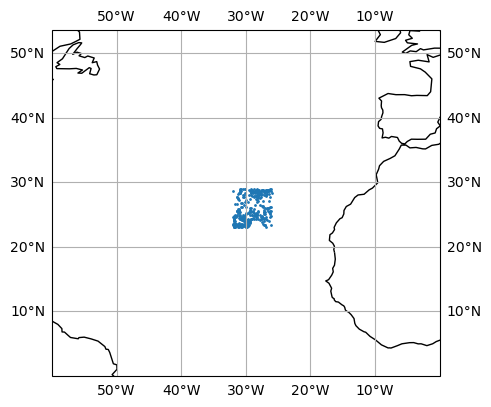

In [170]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([0,-60, 0,50])
ax.gridlines(draw_labels=True)

ax.scatter(ds.LONGITUDE,ds.LATITUDE,transform=ccrs.PlateCarree(),color='tab:blue',label='Section 1: Western North Atlantic',s=1)

### Calculate Terms

In [13]:
lfilt = 100

ct_b = ds.CT
sa_b = ds.SA

ct_m = ff.ds_filt_single(ds, lfilt, 'CT')
sa_m = ff.ds_filt_single(ds, lfilt, 'SA')

ct_e = ct_b - ct_m
sa_e = sa_b - sa_m

In [14]:
K_rho4 = 10**(-4)
K_rho5 = 10**(-5)
K_rho6 = 10**(-6)

In [15]:
ct_2 = K_rho5*ff.da_filt_single((ct_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt)
sa_2 = K_rho5*ff.da_filt_single((sa_e.differentiate(coord='PRES_INTERPOLATED'))**2, lfilt)

ct_3 = K_rho5*(ct_m.differentiate(coord='PRES_INTERPOLATED'))**2
sa_3 = K_rho5*(sa_m.differentiate(coord='PRES_INTERPOLATED'))**2

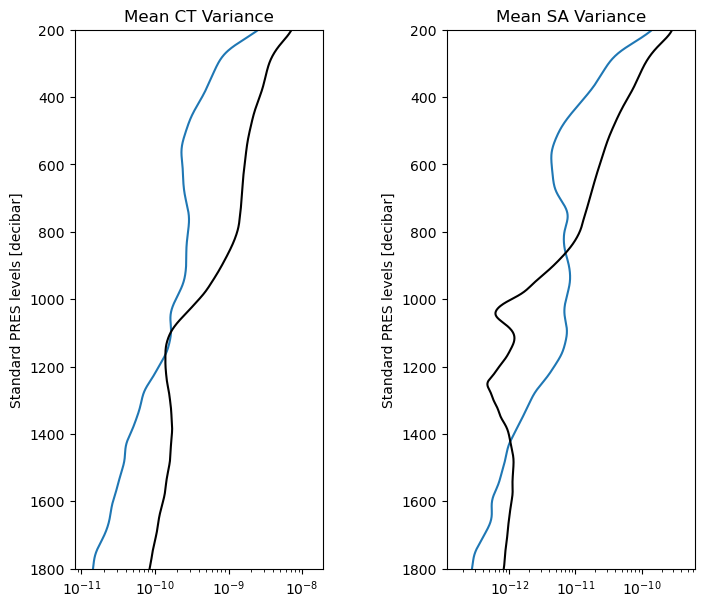

In [136]:
plt.figure(figsize=(8,7))

plt.subplot(121)
ct_2.mean('N_PROF').plot(y='PRES_INTERPOLATED')
ct_3.mean('N_PROF').plot(y='PRES_INTERPOLATED',color='k')
plt.xscale('log')
plt.ylim(1800,200)
plt.title('Mean CT Variance')

plt.subplot(122)
sa_2.mean('N_PROF').plot(y='PRES_INTERPOLATED')
sa_3.mean('N_PROF').plot(y='PRES_INTERPOLATED',color='k')
plt.xscale('log')
plt.ylim(1800,200)
plt.title('Mean SA Variance')

plt.subplots_adjust(wspace=0.5)

Text(0.5, 1.0, 'SA [2]')

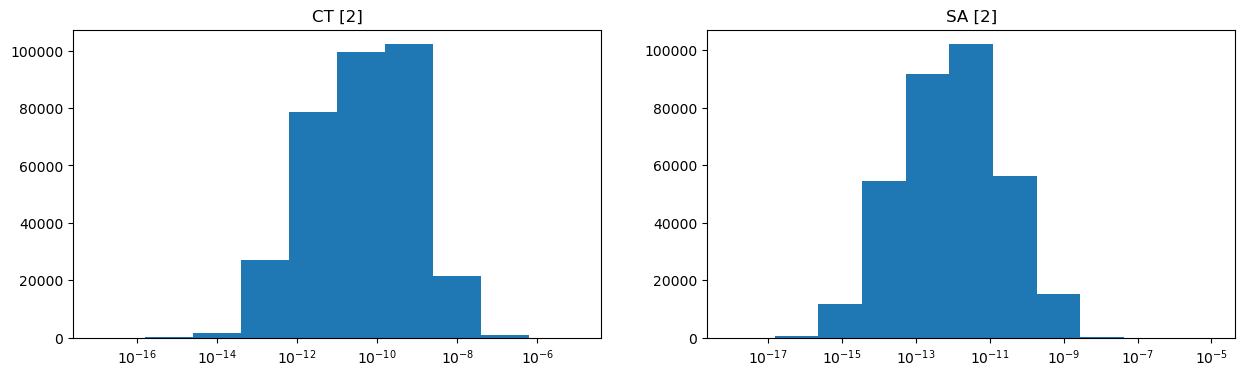

In [22]:
plt.figure(figsize=(15,4))

plt.subplot(121)
bins = np.logspace(-17,-5,num=11)
ct_2.plot.hist(bins=bins)
plt.xscale('log')
plt.title('CT [2]')

plt.subplot(122)
bins = np.logspace(-18,-5,num=12)
sa_2.plot.hist(bins=bins)
plt.xscale('log')
plt.title('SA [2]')

### Variance Sections

In [83]:
x='N_PROF_NEW'
y='PRES_INTERPOLATED'

In [92]:
ct_start = 10**-12
ct_end   = 10**-8
ct_norm  = colors.LogNorm(vmin=ct_start, vmax=ct_end)
ct_cmap  = cmo.matter_r

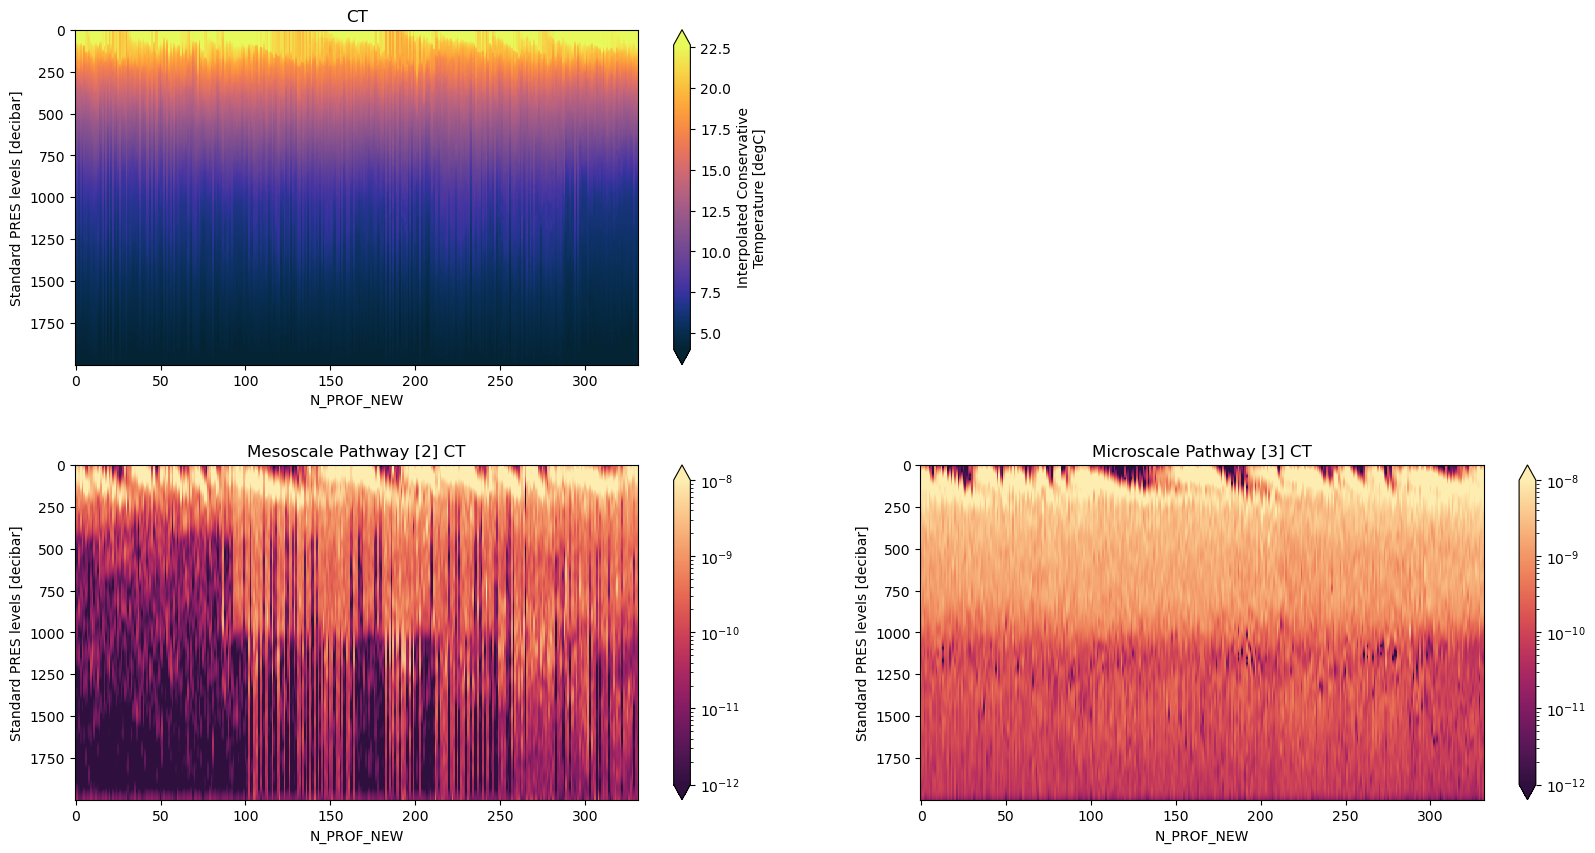

In [116]:
plt.figure(figsize=(20,10))

plt.subplot(221)
ds.CT.sortby(x).plot(x=x, y=y, cmap=cmo.thermal, robust=True)
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(223)
#ct_2.sortby(x).where(ct_2.mask==1).plot(x=x, y=y, norm=ct_norm, cmap=ct_cmap)
ct_2.sortby(x).plot(x=x, y=y, norm=ct_norm, cmap=ct_cmap)
plt.gca().invert_yaxis()
plt.title('Mesoscale Pathway [2] CT')

plt.subplot(224)
#ct_3.sortby(x).where(ct_3.mask==1).plot(x=x, y=y, norm=ct_norm, cmap=ct_cmap)
ct_3.sortby(x).plot(x=x, y=y, norm=ct_norm, cmap=ct_cmap)
plt.gca().invert_yaxis()
plt.title('Microscale Pathway [3] CT')

plt.subplots_adjust(hspace=0.3)

In [94]:
sa_start = 10**-14
sa_end   = 10**-10
sa_norm  = colors.LogNorm(vmin=sa_start, vmax=sa_end)
sa_cmap  = cmo.matter_r

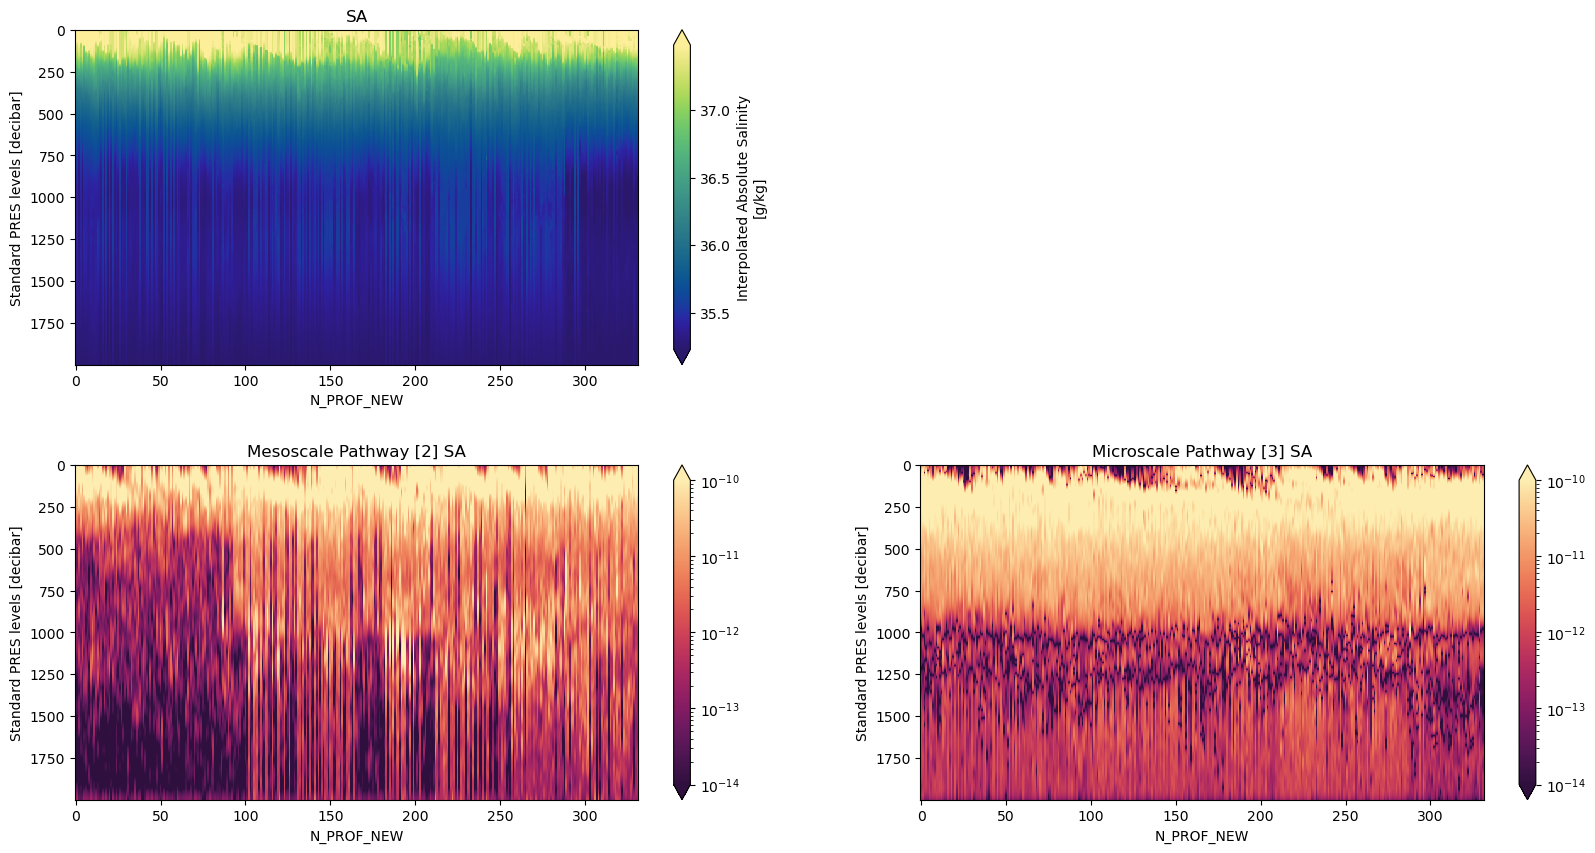

In [117]:
plt.figure(figsize=(20,10))

plt.subplot(221)
ds.SA.sortby(x).plot(x=x, y=y, cmap=cmo.haline, robust=True)
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(223)
#sa_2.sortby(x).where(sa_2.mask==1).plot(x=x, y=y, norm=sa_norm, cmap=sa_cmap)
sa_2.sortby(x).plot(x=x, y=y, norm=sa_norm, cmap=sa_cmap)
plt.gca().invert_yaxis()
plt.title('Mesoscale Pathway [2] SA')

plt.subplot(224)
#sa_3.sortby(x).where(sa_3.mask==1).plot(x=x, y=y, norm=sa_norm, cmap=sa_cmap)
sa_3.sortby(x).plot(x=x, y=y, norm=sa_norm, cmap=sa_cmap)
plt.gca().invert_yaxis()
plt.title('Microscale Pathway [3] SA')

plt.subplots_adjust(hspace=0.3)

### Ratio Sections

In [96]:
ct_tot  = ct_2 + ct_3
ct_2rat = ct_2/ct_tot
ct_3rat = ct_3/ct_tot

sa_tot  = sa_2 + sa_3
sa_2rat = sa_2/sa_tot
sa_3rat = sa_3/sa_tot

In [108]:
ctrat_start = 10**-11
ctrat_end   = 10**-8
ctrat_norm  = colors.LogNorm(vmin=ctrat_start, vmax=ctrat_end)
rat_cmap  = cmo.matter_r

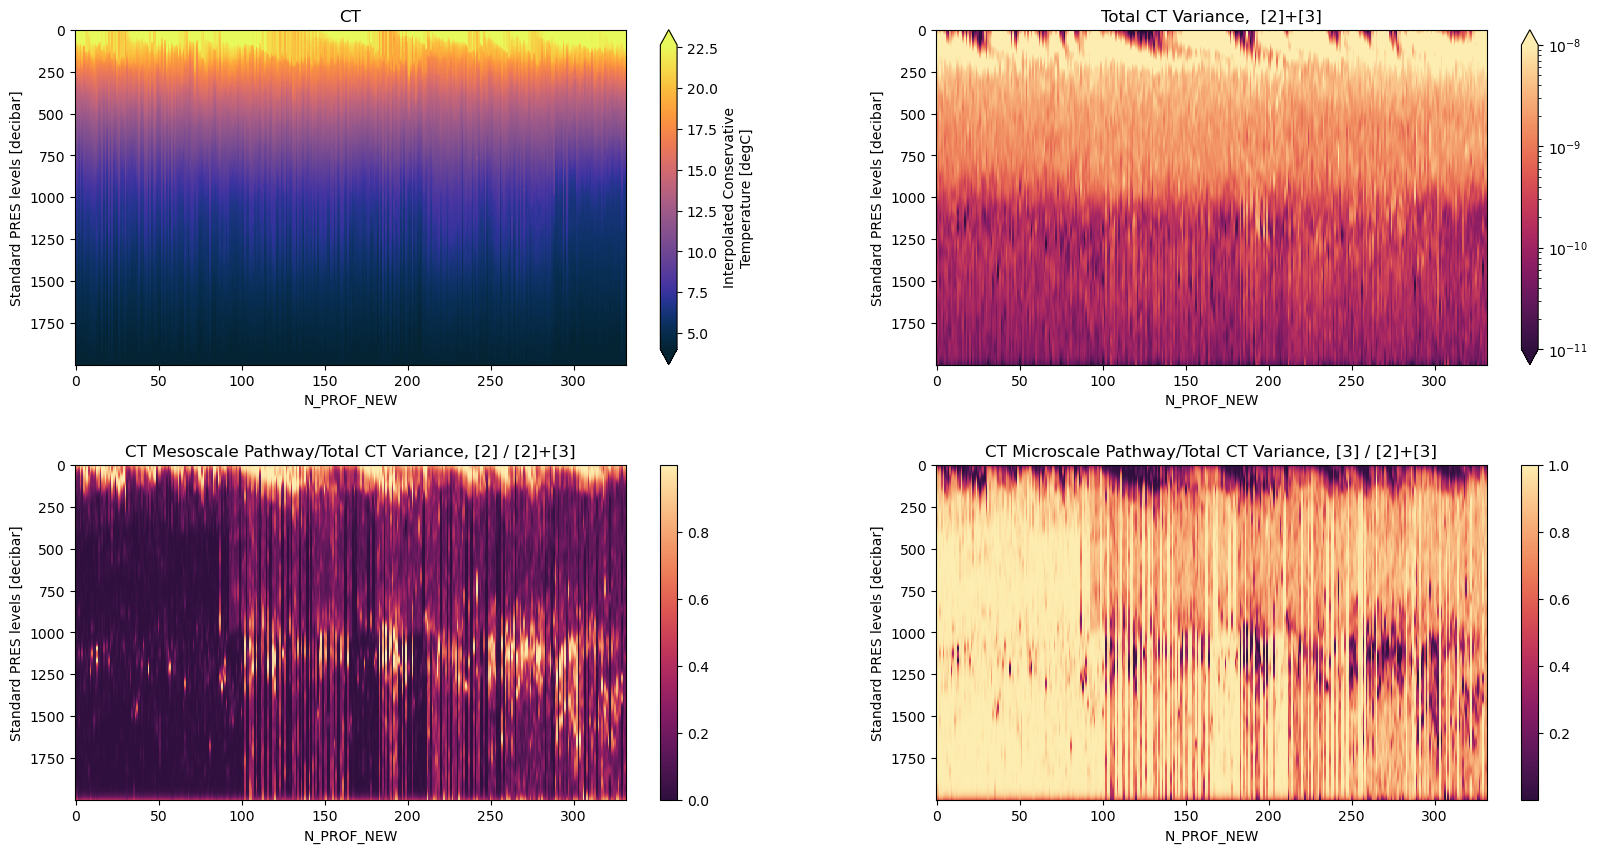

In [118]:
plt.figure(figsize=(20,10))

plt.subplot(221)
ds.CT.sortby(x).plot(x=x, y=y, cmap=cmo.thermal, robust=True)
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(222)
#ct_tot.sortby(x).where(ct_tot.mask==1).plot(x=x, y=y, norm=ctrat_norm, cmap=rat_cmap)
ct_tot.sortby(x).plot(x=x, y=y, norm=ctrat_norm, cmap=rat_cmap)
plt.gca().invert_yaxis()
plt.title('Total CT Variance,  [2]+[3]')

plt.subplot(223)
#ct_2rat.sortby(x).where(ct_2rat.mask==1).plot(x=x, y=y, cmap=rat_cmap)
ct_2rat.sortby(x).plot(x=x, y=y, cmap=rat_cmap)
plt.gca().invert_yaxis()
plt.title('CT Mesoscale Pathway/Total CT Variance, [2] / [2]+[3]')

plt.subplot(224)
#ct_3rat.sortby(x).where(ct_3rat.mask==1).plot(x=x, y=y, cmap=rat_cmap)
ct_3rat.sortby(x).plot(x=x, y=y, cmap=rat_cmap)
plt.gca().invert_yaxis()
plt.title('CT Microscale Pathway/Total CT Variance, [3] / [2]+[3]')

plt.subplots_adjust(hspace=0.3, wspace=0.25)

In [114]:
sarat_start = 10**-13
sarat_end   = 10**-9
sarat_norm  = colors.LogNorm(vmin=sarat_start, vmax=sarat_end)
rat_cmap  = cmo.matter_r

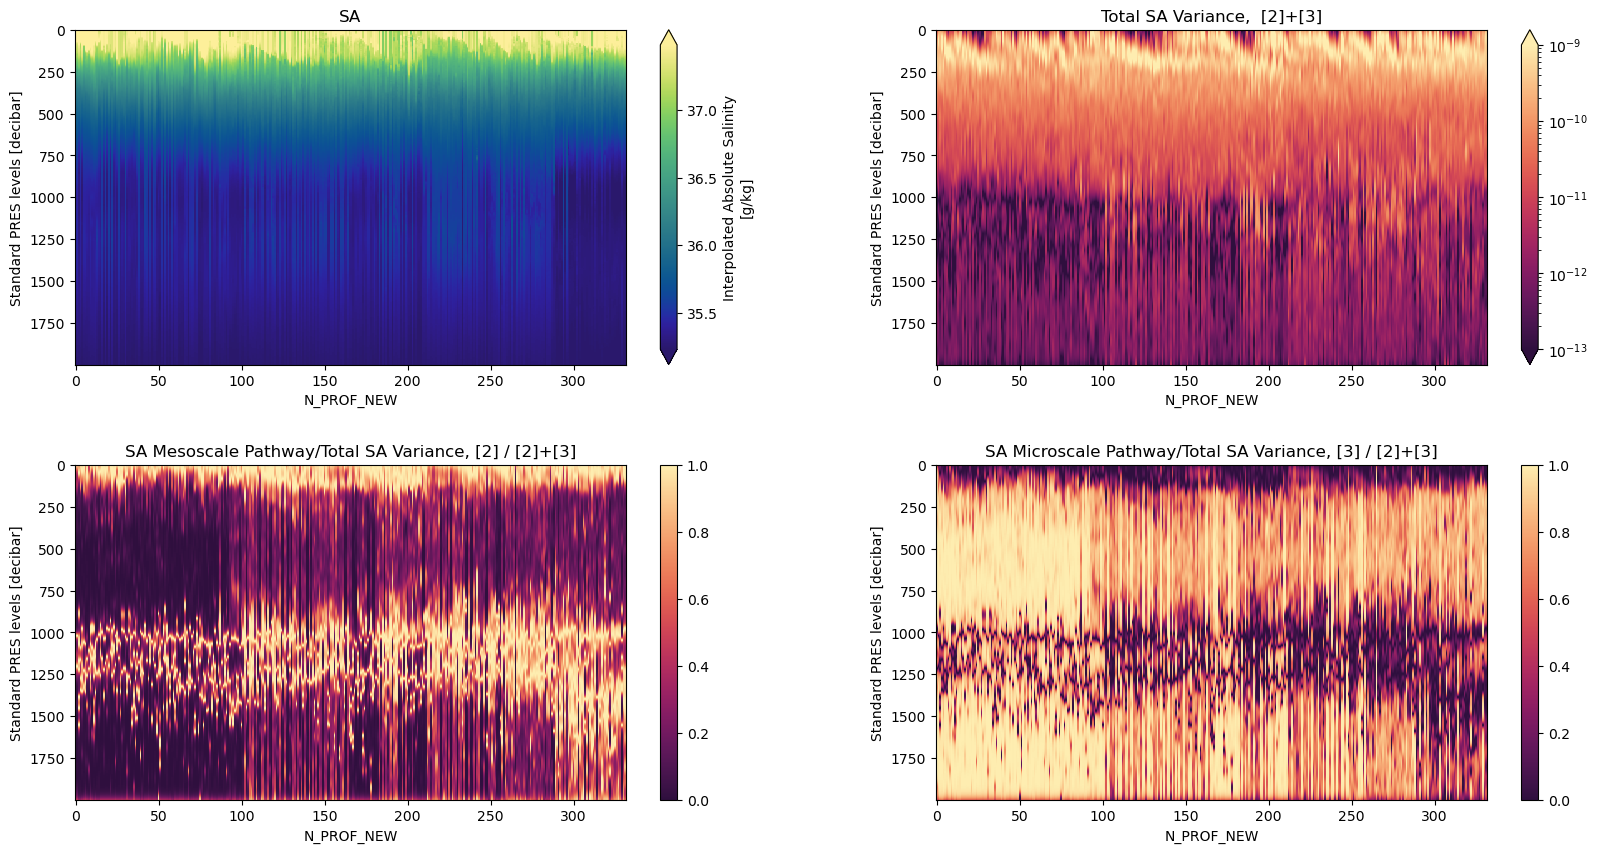

In [119]:
plt.figure(figsize=(20,10))

plt.subplot(221)
ds.SA.sortby(x).plot(x=x, y=y, cmap=cmo.haline, robust=True)
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(222)
#sa_tot.sortby(x).where(sa_tot.mask==1).plot(x=x, y=y, norm=sarat_norm, cmap=rat_cmap)
sa_tot.sortby(x).plot(x=x, y=y, norm=sarat_norm, cmap=rat_cmap)
plt.gca().invert_yaxis()
plt.title('Total SA Variance,  [2]+[3]')

plt.subplot(223)
#sa_2rat.sortby(x).where(sa_2rat.mask==1).plot(x=x, y=y, cmap=cmo.matter_r)
sa_2rat.sortby(x).plot(x=x, y=y, cmap=cmo.matter_r)
plt.gca().invert_yaxis()
plt.title('SA Mesoscale Pathway/Total SA Variance, [2] / [2]+[3]')

plt.subplot(224)
#sa_3rat.sortby(x).where(sa_3rat.mask==1).plot(x=x, y=y, cmap=cmo.matter_r)
sa_3rat.sortby(x).plot(x=x, y=y, cmap=cmo.matter_r)
plt.gca().invert_yaxis()
plt.title('SA Microscale Pathway/Total SA Variance, [3] / [2]+[3]')

plt.subplots_adjust(hspace=0.3, wspace=0.25)